In [1]:
import lhapdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt


# Global Constants
M1_test=np.sqrt(0.8)
Kp2A=0.57
Pp2A=0.12

ee=1
eU=2/3
eUbar=-2/3
eD=-1/3
eDbar=1/3
eS=-1/3
eSbar=1/3

AlphaU_test=1.0
BetaU_test=6.6
AlphaD_test=1.9
BetaD_test=10
AlphaS_test=0
BetaS_test=0

NU_test=0.18
NUbar_test=-0.01
ND_test=-0.52
NDbar_test=-0.06
NS_test=0
NSbar_test=0


Datafile='Data/HERMES_p_2009.csv'
PDFdataset = lhapdf.mkPDF("JAM19PDF_proton_nlo")
#PDFdataset = lhapdf.mkPDF("CT10nnlo")
FF_pion_dataset=["JAM19FF_pion_nlo"]

In [4]:
def dataslice(filename,Had,Var):
    tempdf=pd.read_csv(filename)
    temp_slice=tempdf[(tempdf["hadron"]==Had)&(tempdf["1D_dependence"]==Var)]
    tempQ2=np.array(temp_slice["Q2"])
    tempX=np.array(temp_slice["x"])
    tempZ=np.array(temp_slice["z"])
    tempPHT=np.array(temp_slice["phT"])
    tempSiv=np.array(temp_slice["Siv"])
    temperrSiv=np.array(temp_slice["tot_err"])
    return tempQ2,tempX,tempZ,tempPHT,tempSiv,temperrSiv

def ks2Avg(m1,kperp2Avg):
    test_ks2Avg=((m1**2)*kperp2Avg)/((m1**2)+kperp2Avg)
    return test_ks2Avg

def A0(z,pht,m1,kperp2Avg,pperp2Avg,eCharg):
    tempA0part1=(((z**2)*kperp2Avg+pperp2Avg)*((ks2Avg(m1,kperp2Avg))**2))/((((z**2)*(ks2Avg(m1,kperp2Avg))+pperp2Avg)**2)*kperp2Avg)
    tempA0part21=(pht**2)*(z**2)*(ks2Avg(m1,kperp2Avg) - kperp2Avg)
    tempA0part22=((z**2)*(ks2Avg(m1,kperp2Avg))+pperp2Avg)*((z**2)*kperp2Avg+pperp2Avg)
    tempA0part2=np.exp(-tempA0part21/tempA0part22)
    tempA0part3=(np.sqrt(2*eCharg))*z*pht/m1
    tempA0=tempA0part1*tempA0part2*tempA0part3
    return tempA0

def NNq(x,Nq,aq,bq):
    tempNNq = Nq*(x**aq)*((1-x)**(bq))*((aq+bq)**(aq+bq))/((aq**aq)*(bq**bq))
    return tempNNq

def NNqbar(x,Nqbar):
    tempNNqbar = Nqbar
    return tempNNqbar

def xFxQ2(dataset,flavor,x,QQ):
    temp_parton_dist_x=(dataset.xfxQ2(flavor, x, QQ))
    return temp_parton_dist_x

def zFzQ(dataset,flavor,zz,QQ):
    # Here "0" represents the central values from the girds
    temp_zD1=lhapdf.mkPDF(dataset[0], 0)
    zD1_vec=(temp_zD1.xfxQ2(flavor,zz,QQ))
    return zD1_vec

def Asymmetry(QQ,x,z,pht,m1,Nq,aq,bq,Nqbar,eq,eqbar,lhaqID,lhaqbarID):
    kperp2Avg=Kp2A
    pperpAvg=Pp2A
    eCharg=ee
    Ucontribution1 = NNq(x,Nq,aq,bq)*(eq**2)*xFxQ2(PDFdataset,lhaqID,x,QQ)*zFzQ(FF_pion_dataset,lhaqID,z,QQ)
    dbarcontribution1 = NNqbar(x,Nqbar)*(eqbar**2)*xFxQ2(PDFdataset,lhaqbarID,x,QQ)*zFzQ(FF_pion_dataset,lhaqbarID,z,QQ)
    Ucontribution2 = (eq**2)*xFxQ2(PDFdataset,lhaqID,x,QQ)*zFzQ(FF_pion_dataset,lhaqID,z,QQ)
    dbarcontribution2 = (eqbar**2)*xFxQ2(PDFdataset,lhaqbarID,x,QQ)*zFzQ(FF_pion_dataset,lhaqbarID,z,QQ)
    tempNumerator = Ucontribution1 + dbarcontribution1
    tempDenominator = Ucontribution2 + dbarcontribution2
    tempASivPiP = A0(z,pht,m1,kperp2Avg,pperpAvg,eCharg)*tempNumerator/tempDenominator
    return tempASivPiP
    
    

In [12]:
### Definitions for hadron = Pi_plus ####

def ASivPiPFitting(KV,m1,Nu,alphau,betau,Ndbar):
    QQ,x,z,pht=KV
    array_size=len(x)
    tempASivPiP_val=[]
    for i in range(0,array_size):
        tempASivPiP=Asymmetry(QQ[i],x[i],z[i],pht[i],m1,Nu,alphau,betau,Ndbar,eU,eDbar,2,-1)
        tempASivPiP_val.append(tempASivPiP)
    return tempASivPiP_val

def Chi2PiP(datfile,hadron,dependence,m1,Nu,alphau,betau,Ndbar):
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivPiPFitting((tempQ,tempX,tempZ,tempphT),m1,Nu,alphau,betau,Ndbar)
    temp_Chi2_val=np.sum(((temp_theory-temp_exp)/temp_sigma)**2)
    return temp_Chi2_val


### Definitions for hadron = Pi_minus ####

def ASivPiMFitting(KV,m1,Nd,alphad,betad,Nubar):
    QQ,x,z,pht=KV
    array_size=len(x)
    tempASivPiP_val=[]
    for i in range(0,array_size):
        tempASivPiP=Asymmetry(QQ[i],x[i],z[i],pht[i],m1,Nd,alphad,betad,Nubar,eD,eUbar,1,-2)
        tempASivPiP_val.append(tempASivPiP)
    return tempASivPiP_val

def Chi2PiM(datfile,hadron,dependence,m1,Nd,alphad,betad,Nubar):
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivPiMFitting((tempQ,tempX,tempZ,tempphT),m1,Nd,alphad,betad,Nubar)
    temp_Chi2_val=np.sum(((temp_theory-temp_exp)/temp_sigma)**2)
    return temp_Chi2_val


### Definitions for hadron = Pi_0 ####

def ASivPi0Fitting(KV,m1,Nu,alphau,betau,Nubar):
    QQ,x,z,pht=KV
    array_size=len(x)
    tempASivPi0_val=[]
    for i in range(0,array_size):
        tempASivPi0=Asymmetry(QQ[i],x[i],z[i],pht[i],m1,Nu,alphau,betau,Nubar,eU,eUbar,2,-2)
        tempASivPi0_val.append(tempASivPi0)
    return tempASivPi0_val

def Chi2Pi0(datfile,hadron,dependence,m1,Nu,alphau,betau,Nubar):
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivPi0Fitting((tempQ,tempX,tempZ,tempphT),m1,Nu,alphau,betau,Nubar)
    temp_Chi2_val=np.sum(((temp_theory-temp_exp)/temp_sigma)**2)
    return temp_Chi2_val


### Definitions for hadron = K_plus ####

def ASivKPFitting(KV,m1,Nu,alphau,betau,Nsbar):
    QQ,x,z,pht=KV
    array_size=len(x)
    tempASivKP_val=[]
    for i in range(0,array_size):
        tempASivKP=Asymmetry(QQ[i],x[i],z[i],pht[i],m1,Nu,alphau,betau,Nsbar,eU,eSbar,2,-3)
        tempASivKP_val.append(tempASivKP)
    return tempASivKP_val

def Chi2KP(datfile,hadron,dependence,m1,Nu,alphau,betau,Nsbar):
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivKPFitting((tempQ,tempX,tempZ,tempphT),m1,Nu,alphau,betau,Nsbar)
    temp_Chi2_val=np.sum(((temp_theory-temp_exp)/temp_sigma)**2)
    return temp_Chi2_val


### Definitions for hadron = K_minus ####

def ASivKMFitting(KV,m1,Ns,alphas,betas,Nubar):
    QQ,x,z,pht=KV
    array_size=len(x)
    tempASivKM_val=[]
    for i in range(0,array_size):
        tempASivKM=Asymmetry(QQ[i],x[i],z[i],pht[i],m1,Ns,alphas,betas,Nubar,eS,eUbar,3,-2)
        tempASivKM_val.append(tempASivKM)
    return tempASivKM_val

def Chi2KM(datfile,hadron,dependence,m1,Ns,alphas,betas,Nubar):
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivKMFitting((tempQ,tempX,tempZ,tempphT),m1,Ns,alphas,betas,Nubar)
    temp_Chi2_val=np.sum(((temp_theory-temp_exp)/temp_sigma)**2)
    return temp_Chi2_val



def totalfit(KV,m1,Nu,alphau,betau,Ndbar,Nd,alphad,betad,Nubar,Ns,alphas,betas,Nsbar):
    KV1PiP,KVPiM,KVPi0,KVKP,KVKM = KV
    fitPiP=ASivPiPFitting(KV1PiP,m1,Nu,alphau,betau,Ndbar)
    fitPiM=ASivPiMFitting(KVPiM,m1,Nd,alphad,betad,Nubar)
    fitPi0=ASivPi0Fitting(KVPi0,m1,Nu,alphau,betau,Nubar)
    fitKP =ASivKPFitting(KVKP,m1,Nu,alphau,betau,Nsbar)
    fitKM =ASivKMFitting(KVKM,m1,Ns,alphas,betas,Nubar)
    testtotalfit=np.concatenate((fitPiP,fitPiM,fitPi0,fitKP,fitKM))
    return testtotalfit

#totalfit((Kin_hadron(Datafile,"pi+"),Kin_hadron(Datafile,"pi-")),M1_test,NU_test,AlphaU_test,BetaU_test,NDbar_test,ND_test,AlphaD_test,BetaD_test,NUbar_test)

In [13]:
### Here we concatenate data corresponding to a given hadron in the SIDIS process

def Kin_hadron(datfile,hadron):
    ##### Q2 ################
    tempQ2_x=np.array(dataslice(datfile,hadron,"x")[0])
    tempQ2_z=np.array(dataslice(datfile,hadron,"z")[0])
    tempQ2_phT=np.array(dataslice(datfile,hadron,"phT")[0])
    tempQ2=np.concatenate((tempQ2_x,tempQ2_z,tempQ2_phT))
    ##### X ################
    tempX_x=np.array(dataslice(datfile,hadron,"x")[1])
    tempX_z=np.array(dataslice(datfile,hadron,"z")[1])
    tempX_phT=np.array(dataslice(datfile,hadron,"phT")[1])
    tempX=np.concatenate((tempX_x,tempX_z,tempX_phT))
    ##### Z ################
    tempZ_x=np.array(dataslice(datfile,hadron,"x")[2])
    tempZ_z=np.array(dataslice(datfile,hadron,"z")[2])
    tempZ_phT=np.array(dataslice(datfile,hadron,"phT")[2])
    tempZ=np.concatenate((tempZ_x,tempZ_z,tempZ_phT))
    ##### phT ################
    tempphT_x=np.array(dataslice(datfile,hadron,"x")[3])
    tempphT_z=np.array(dataslice(datfile,hadron,"z")[3])
    tempphT_phT=np.array(dataslice(datfile,hadron,"phT")[3])
    tempphT=np.concatenate((tempphT_x,tempphT_z,tempphT_phT))
    return tempQ2,tempX,tempZ,tempphT

  
def ASiv_data(datfile,hadron):
    ##### Asy ################
    tempAsy_x=np.array(dataslice(datfile,hadron,"x")[4])
    tempAsy_z=np.array(dataslice(datfile,hadron,"z")[4])
    tempAsy_phT=np.array(dataslice(datfile,hadron,"phT")[4])
    tempAsy=np.concatenate((tempAsy_x,tempAsy_z,tempAsy_phT))
    ##### err ################
    tempAsyErr_x=np.array(dataslice(datfile,hadron,"x")[5])
    tempAsyErr_z=np.array(dataslice(datfile,hadron,"z")[5])
    tempAsyErr_phT=np.array(dataslice(datfile,hadron,"phT")[5])
    tempAsyErr=np.concatenate((tempAsyErr_x,tempAsyErr_z,tempAsyErr_phT))
    return tempAsy,tempAsyErr


In [14]:
def KinConcat(datfile):
    PiP_data=Kin_hadron(Datafile,"pi+")
    PiM_data=Kin_hadron(Datafile,"pi-")
    Pi0_data=Kin_hadron(Datafile,"pi0")
    KP_data =Kin_hadron(Datafile,"k+")
    KM_data =Kin_hadron(Datafile,"k-")
    testQ  =np.concatenate((PiP_data[0],PiM_data[0],Pi0_data[0],KP_data[0],KM_data[0]))
    testX  =np.concatenate((PiP_data[1],PiM_data[1],Pi0_data[1],KP_data[1],KM_data[1]))
    testZ  =np.concatenate((PiP_data[2],PiM_data[2],Pi0_data[2],KP_data[2],KM_data[2]))
    testphT=np.concatenate((PiP_data[3],PiM_data[3],Pi0_data[3],KP_data[3],KM_data[3]))
    return testQ,testX,testZ,testphT


#print(KinConcat(Datafile)[3])

In [15]:
### Fitting to the data for single hadron (all x,z,phT dependencies are considered)    
#kin=np.concatenate((Kin_hadron(Datafile,"pi+"),Kin_hadron(Datafile,"pi-")))
ASiv_PiP_dat=ASiv_data(Datafile,"pi+")
ASiv_PiM_dat=ASiv_data(Datafile,"pi-")
ASiv_Pi0_dat=ASiv_data(Datafile,"pi0")
ASiv_KP_dat=ASiv_data(Datafile,"k+")
ASiv_KM_dat=ASiv_data(Datafile,"k-")
test_func=np.concatenate((ASiv_PiP_dat[0],ASiv_PiM_dat[0],ASiv_Pi0_dat[0],ASiv_KP_dat[0],ASiv_KM_dat[0]))
test_func_err=np.concatenate((ASiv_PiP_dat[1],ASiv_PiM_dat[1],ASiv_Pi0_dat[1],ASiv_KP_dat[1],ASiv_KM_dat[1]))

#p0=1,1,1,1,1,1,1,1,1
p0=1,1,1,1,1,1,1,1,1,1,1,1,1
#p0=M1_test,NU_test,AlphaU_test,BetaU_test,NDbar_test
Kin_PiP=Kin_hadron(Datafile,"pi+")
Kin_PiM=Kin_hadron(Datafile,"pi-")
Kin_Pi0=Kin_hadron(Datafile,"pi0")
Kin_KP=Kin_hadron(Datafile,"k+")
Kin_KM=Kin_hadron(Datafile,"k-")
result, result_cov=opt.curve_fit(totalfit,(Kin_PiP,Kin_PiM,Kin_Pi0,Kin_KP,Kin_KM),test_func,p0,sigma=test_func_err,method='lm')
#print(len(KinConcat(Datafile)[0]))
#print(len(test_func))
#print(len(test_func_err))

<ipython-input-4-88435a4b36f3>:26: RuntimeWarning: invalid value encountered in double_scalars
  tempNNq = Nq*(x**aq)*((1-x)**(bq))*((aq+bq)**(aq+bq))/((aq**aq)*(bq**bq))


In [16]:
#Kin_hadron(Datafile,"pi+"),Kin_hadron(Datafile,"pi-"),Kin_hadron(Datafile,"pi0")
test_func

array([ 0.0385,  0.0264,  0.0542,  0.0516,  0.0361,  0.0531,  0.0546,
        0.0333,  0.0365,  0.0348,  0.0463,  0.0577,  0.0623,  0.0803,
        0.0039,  0.0233,  0.0334,  0.0594,  0.0602,  0.063 ,  0.0632,
        0.0104,  0.0169, -0.0157,  0.0103, -0.0053,  0.0204, -0.0192,
        0.0088,  0.0072,  0.0205,  0.0007, -0.0007,  0.0117, -0.0099,
        0.0078,  0.0122,  0.0069, -0.0064,  0.0044,  0.0026,  0.0292,
        0.0113, -0.0331,  0.0585,  0.0264,  0.0174,  0.0419,  0.0784,
        0.0387, -0.0006,  0.0325,  0.0487,  0.0239,  0.0162,  0.1001,
        0.0128,  0.0667,  0.0625,  0.0575,  0.0177,  0.0315,  0.0196])

In [16]:
print(result)

[ 4.84623884e+00  5.27836322e-01  2.28554017e+00  8.75565812e+00
  2.17046485e+00 -8.22018501e-02  8.63362466e-06  3.55997681e-02
  1.84947726e-01 -2.96004609e+00  2.12157887e+01  3.87708461e+01
  5.66296670e+01]


In [69]:
print(result)

[ 52.27395415   5.37068263   0.8055731    2.62195407   4.97493299
 -35.50804798  52.04655842  90.95942629   1.07020814]


In [51]:
dep="x"

In [52]:
dep="x"
Chi2PiP(Datafile,"pi+",dep,result[0],result[1],result[2],result[3],result[4]) 

10.098190679925855

10.932523808838047


(0.0, 0.35)

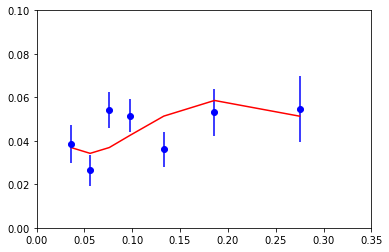

In [17]:
dep="x"

print(Chi2PiP(Datafile,"pi+",dep,result[0],result[1],result[2],result[3],result[4]))

def PlotSiversPiP(datfile,hadron,dependence,m1,Nu,alphau,betau,Ndbar):
    kperp2Avg=Kp2A
    pperpAvg=Pp2A
    eCharg=ee
    eu=eU
    edbar=eDbar
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    if(dependence=="x"):
        dep_index=1
    elif(dependence=="z"):
        dep_index=2
    elif(dependence=="phT"):
        dep_index=3
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivPiPFitting((tempQ,tempX,tempZ,tempphT),m1,Nu,alphau,betau,Ndbar)
    plt.plot(temp_kinematics[dep_index],temp_theory,'red')
    plt.errorbar(temp_kinematics[dep_index],temp_kinematics[4],temp_kinematics[5],fmt='o',color='blue')

PlotSiversPiP(Datafile,"pi+",dep,result[0],result[1],result[2],result[3],result[4])
plt.ylim(0.0,0.1)
plt.xlim(0.0,0.35)

In [86]:
### This shows the solution by Anzelmino's fit results
##PlotSiversPiP(Datafile,"pi+",dep,M1_test,NU_test,AlphaU_test,BetaU_test,NDbar_test)

12.125417572672582
473.58852527244085


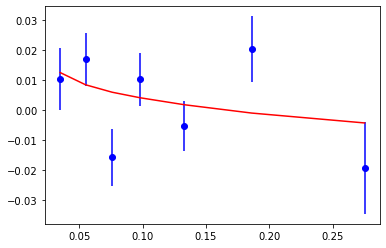

In [18]:
dep="x"

print(Chi2PiM(Datafile,"pi-",dep,result[0],result[5],result[6],result[7],result[8]))
print(Chi2PiM(Datafile,"pi-",dep,M1_test,ND_test,AlphaD_test,BetaD_test,NUbar_test))

def PlotSiversPiM(datfile,hadron,dependence,m1,Nd,alphad,betad,Nubar):
    kperp2Avg=Kp2A
    pperpAvg=Pp2A
    eCharg=ee
    eu=eU
    edbar=eDbar
    data_points=len(dataslice(datfile,hadron,dependence)[0])
    temp_kinematics=np.array(dataslice(datfile,hadron,dependence))
    if(dependence=="x"):
        dep_index=1
    elif(dependence=="z"):
        dep_index=2
    elif(dependence=="phT"):
        dep_index=3
    tempQ=temp_kinematics[0]
    tempX=temp_kinematics[1]
    tempZ=temp_kinematics[2]
    tempphT=temp_kinematics[3]
    temp_exp=temp_kinematics[4]
    temp_sigma=temp_kinematics[5]
    temp_theory=ASivPiMFitting((tempQ,tempX,tempZ,tempphT),m1,Nd,alphad,betad,Nubar)
    plt.plot(temp_kinematics[dep_index],temp_theory,'red')
    plt.errorbar(temp_kinematics[dep_index],temp_kinematics[4],temp_kinematics[5],fmt='o',color='blue')

PlotSiversPiM(Datafile,"pi-",dep,result[0],result[5],result[6],result[7],result[8])

In [87]:
### This shows the solution by Anzelmino's fit results
##PlotSiversPiM(Datafile,"pi-",dep,M1_test,ND_test,AlphaD_test,BetaD_test,NUbar_test)